<a href="https://colab.research.google.com/github/pacomm5/PLANTILLAS2/blob/main/SERIE_TEMPORAL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CLONAMOS EL REPOSITORIO DE GITHUB PARA OBTENER EL DATASET

In [1]:
# si ponemos la dirección que tengo debajo lo que estoy clonando es el original, pero
# no el que tenga guardado yo en github. 
#!git clone https://github.com/joanby/machinelearning-az.git
! git clone https://github.com/pacomm5/time-series-analysis # de esta manera lo que hacemos es acceder a todos los datasets mios de github. en este caso de marchine learning de la a a la z

Cloning into 'time-series-analysis'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 78 (delta 15), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (78/78), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("/content/time-series-analysis/data/daily_traffic.csv")
data = data.dropna()
data.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


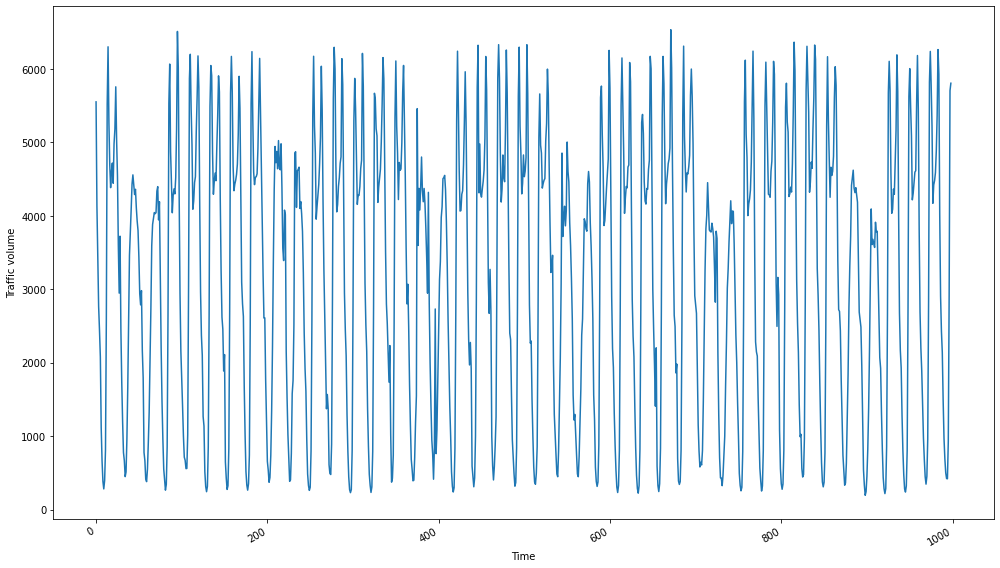

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(data['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
# según podemos ver debajo hay dos claros periodos estacionales. 

- ahora lo que vamos a hacer es zoom, y etiquetar los días de la semana. 

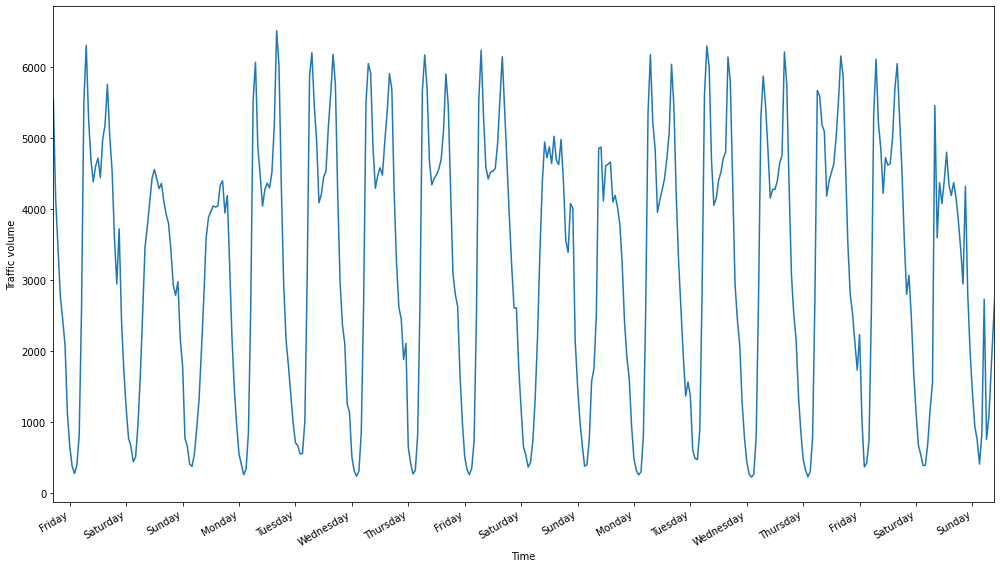

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(data['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- podemos ver que hay más tráfico de lunes a viernes que los fines de semana, y más coches de dia que de noche. 
- el periodo diario tiene 24 horas y el periodo semanal tiene una duración de 168 horas

#Modelado

- tenemos que elegir cual va a ser el horizonte de previsión de datos que queremos elegir. 
- Elegimos una semana de datos. dado que tenemos datos por hora, debemos predecir 168 pasos de tiempo que es 7 x 24

In [9]:
y = data['traffic_volume']

fh = np.arange(1, 168)

- Ahora lo que hacemos es dividir nuestros datos en train y test. 
- la última semana será nuestro test. 

In [12]:
!pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 45.1 MB/s 
     |████████████████████████████████| 9.8 MB 16.5 MB/s 
     |████████████████████████████████| 34.5 MB 12 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [13]:
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=168)

- con lo de debajo vamos a ver nuestro conjunto de test.

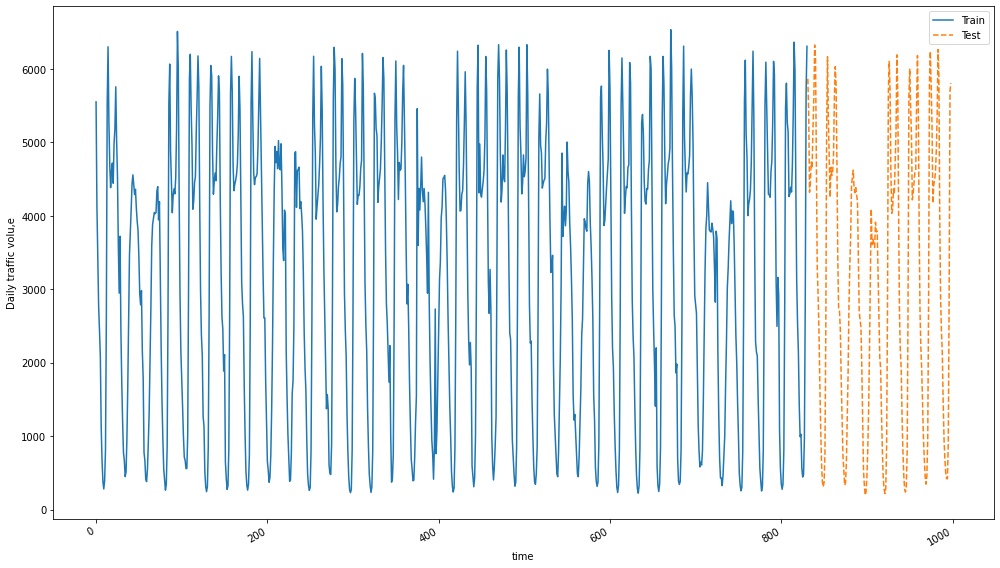

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='--', label='Test')
ax.set_xlabel('time')
ax.set_ylabel('Daily traffic volu,e')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- la linea naranja es el conjunto de test

## modelo de linea base

- Antes de implementar BATS Y TBATS, es bueno tener un modelo de referencia, para comprobar que nuestros modelos son eficientes. 
- lo que hacemos es repetir la última semana de datos del conjunto de entrenamiento en el futuro. 

In [15]:
y_pred_baseline = y_train[-168:].values

## APLICACION MTD

- pasamos a implementar el modelo BATS
- Utilizamos la transformación Box-Cox ya que estamos tratando con datos no lineales. 
- nuestro modelo no tiene una tendencia aparente por lo tanto eliminamos ese componente
- fijamos los periodos estacionales que son 24 para la estacionalidad diaria y 168 para la estacionalidad semanal. 


## BATS

In [18]:
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.4 MB 12.4 MB/s 


In [19]:
from sktime.forecasting.bats import BATS

forecaster = BATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[24, 168])
forecaster.fit(y_train)

y_pred_BATS = forecaster.predict(fh)

In [21]:
y_pred_BATS

831    5565.224100
832    4991.030432
833    4357.775513
834    4574.894425
835    4750.049003
          ...     
993     386.845346
994     458.049884
995     959.666362
996    2863.245239
997    5683.049461
Name: traffic_volume, Length: 167, dtype: float64

In [22]:
pd.DataFrame(y_pred_BATS) # aqui lo estoy convirtiendo en un dataframe para guardarlo en un csv ya que ha tardado bastante en ejecutarse

,traffic_volume
831,5565.224100
832,4991.030432
833,4357.775513
834,4574.894425
835,4750.049003
...,...
993,386.845346
994,458.049884
995,959.666362
996,2863.245239


In [26]:
y_pred_BATS.to_csv("/content/drive/MyDrive/y_pred_BATS_ejecutado.csv") # así he guardado la ejecución en drive de google. Está en mydrive /content/drive/MyDrive

## TBATS

In [27]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(use_box_cox=True,
                   use_trend=False,
                   use_damped_trend=False,
                   sp=[24, 168])
forecaster.fit(y_train)

y_pred_TBATS = forecaster.predict(fh)

In [28]:
y_pred_TBATS.to_csv("/content/drive/MyDrive/y_pred_TBATS_ejecutado.csv") # así he guardado la ejecución en drive de google. Está en mydrive /content/drive/MyDrive